
=== SGD branch | SGD ===
MSE_A after Task A: 0.0399
Training on Task B …
MSE_A after B: 0.3274 (Δ +0.2876)
Training on Task C …
MSE_A after C: 0.5061 (Δ +0.4662)

=== OGD branch | OGD ===
MSE_A after Task A: 0.0563
Training on Task B …
MSE_A after B: 0.1959 (Δ +0.1396)
Training on Task C …
MSE_A after C: 0.2544 (Δ +0.1981)


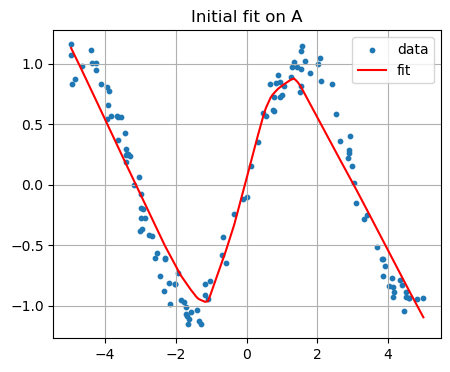

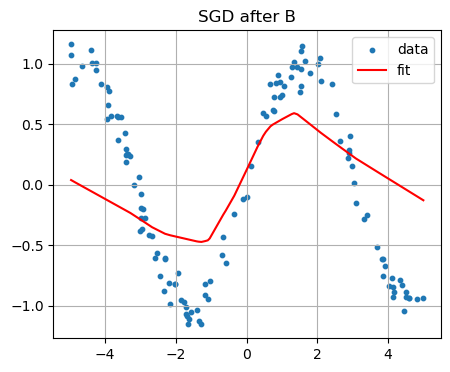

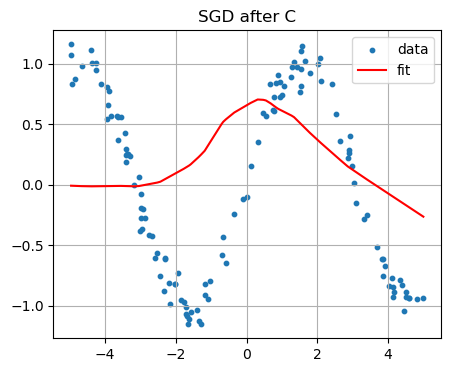

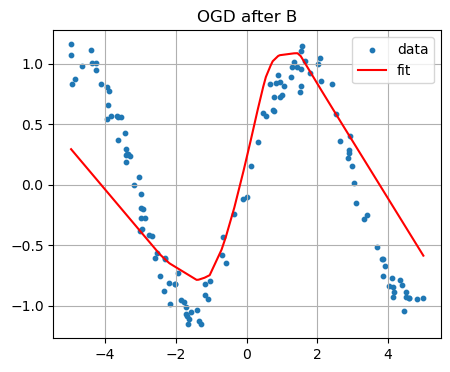

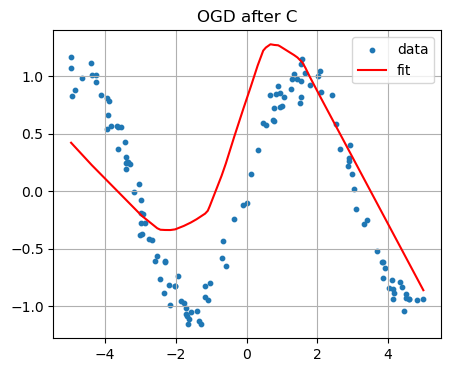

In [1]:
import torch, torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np
from copy import deepcopy

torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

def f_A(x):
    return torch.sin(x)

def f_B(x):
    return torch.sin(x**3)

def f_C(x):
    return torch.exp(-x ** 2)

def make_dataset(f, n=128, rng=(-5, 5), noise_std=0.1):
    a, b = rng
    x = torch.rand(n, 1, device=device) * (b - a) + a
    x, _ = torch.sort(x, dim=0)
    y = f(x) + noise_std * torch.randn_like(x)
    return x, y

x_A, y_A = make_dataset(f_A)
x_B, y_B = make_dataset(f_B)
x_C, y_C = make_dataset(f_C)

class SimpleNN(nn.Module):
    def __init__(self, hidden=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

def flat_gradients(model):
    return torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])

def write_flat_to_grads(model, vec):
    i = 0
    for p in model.parameters():
        if p.grad is None:
            continue
        n = p.numel()
        p.grad.copy_(vec[i : i + n].view_as(p))
        i += n

def train(model, x, y, epochs=250, lr=1e-2, memory=None):
    crit = nn.MSELoss()
    opt = optim.SGD(model.parameters(), lr=lr)
    for _ in range(epochs):
        opt.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        if memory:
            g = flat_gradients(model)
            for v in memory:
                g -= torch.dot(g, v) / (v.norm() ** 2 + 1e-8) * v
            write_flat_to_grads(model, g)
        opt.step()
    return loss.item()

def gradient_of_task(model, x, y):
    model.zero_grad()
    nn.MSELoss()(model(x), y).backward()
    return flat_gradients(model).detach()

def run_branch(name, use_ogd):
    print(f"\n=== {name} | {'OGD' if use_ogd else 'SGD'} ===")
    base_model = SimpleNN().to(device)
    train(base_model, x_A, y_A)
    mse_A_start = nn.MSELoss()(base_model(x_A), y_A).item()
    print(f"MSE_A after Task A: {mse_A_start:.4f}")
    memory = []
    if use_ogd:
        memory.append(gradient_of_task(base_model, x_A, y_A))
    model_B = deepcopy(base_model)
    model_C = deepcopy(base_model)
    print("Training on Task B …")
    train(model_B, x_B, y_B, memory=memory if use_ogd else None)
    mse_A_after_B = nn.MSELoss()(model_B(x_A), y_A).item()
    print(f"MSE_A after B: {mse_A_after_B:.4f} (Δ {mse_A_after_B - mse_A_start:+.4f})")
    if use_ogd:
        memory.append(gradient_of_task(model_B, x_B, y_B))
    print("Training on Task C …")
    train(model_C, x_C, y_C, memory=memory if use_ogd else None)
    mse_A_after_C = nn.MSELoss()(model_C(x_A), y_A).item()
    print(f"MSE_A after C: {mse_A_after_C:.4f} (Δ {mse_A_after_C - mse_A_start:+.4f})")
    return base_model, model_B, model_C

model_A0_sgd, model_B_sgd, model_C_sgd = run_branch("SGD branch", use_ogd=False)
model_A0_ogd, model_B_ogd, model_C_ogd = run_branch("OGD branch", use_ogd=True)

def plot_fit(model, x, y, title):
    model.eval()
    with torch.no_grad():
        p = model(x).cpu()
    plt.figure(figsize=(5, 4))
    plt.scatter(x.cpu(), y.cpu(), s=10, label="data")
    plt.plot(x.cpu(), p, c="r", label="fit")
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

plot_fit(model_A0_sgd, x_A, y_A, "Initial fit on A")
plot_fit(model_B_sgd, x_A, y_A, "SGD after B")
plot_fit(model_C_sgd, x_A, y_A, "SGD after C")
plot_fit(model_B_ogd, x_A, y_A, "OGD after B")
plot_fit(model_C_ogd, x_A, y_A, "OGD after C")

